In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
from tensorflow.keras.regularizers import l2

print("Tüm kütüphaneler başarıyla import edildi!")


Tüm kütüphaneler başarıyla import edildi!


In [ ]:

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("GPU kullanımı için bellek büyümesi etkinleştirildi")
else:
    print("GPU bulunamadı, CPU kullanılacak")


GPU kullanımı için bellek büyümesi etkinleştirildi


In [ ]:
# Sabit değişkenler
IMAGE_SIZE = 224  # VGG16 için standart boyut
BATCH_SIZE = 16
EPOCHS = 40  # Daha uzun eğitim süresi
NUM_CLASSES = 5  # 0, 1, 2, 3, 4 olmak üzere 5 farklı DR seviyesi
LEARNING_RATE = 5e-4  # Arttırılmış öğrenme oranı (1e-4 -> 5e-4)
DROPOUT_RATE = 0.5    # Azaltılmış dropout (0.6 -> 0.4)
L2_LAMBDA = 0.0005    # Azaltılmış L2 regularizasyon katsayısı (0.001 -> 0.0001)

# Veri yolları
image_dir = "/content/drive/MyDrive/B. Disease Grading/1. Original Images/a. Training Set"
csv_path = "/content/drive/MyDrive/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
MODEL_PATH = "/content/drive/MyDrive/dr_vgg16_model_regularized.h5"

# Sonuçları kaydetmek için klasör
RESULT_DIR = "/content/drive/MyDrive/dr_results_regularized"
os.makedirs(RESULT_DIR, exist_ok=True)


In [ ]:
# Pandas kütüphanesini yükle ve import et
!pip install pandas
import pandas as pd
print("Pandas sürümü:", pd.__version__)

Pandas sürümü: 2.2.2


In [ ]:
# Google Drive'a bağlan
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# CSV dosyasını oku
csv_path = "/content/drive/MyDrive/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
df = pd.read_csv(csv_path, usecols=['Image name', 'Retinopathy grade'])
print("CSV dosyası başarıyla okundu!")
print(f"Toplam kayıt sayısı: {len(df)}")
print("\nİlk 5 kayıt:")
print(df.head())

Mounted at /content/drive
CSV dosyası başarıyla okundu!
Toplam kayıt sayısı: 413

İlk 5 kayıt:
  Image name  Retinopathy grade
0  IDRiD_001                  3
1  IDRiD_002                  3
2  IDRiD_003                  2
3  IDRiD_004                  3
4  IDRiD_005                  4


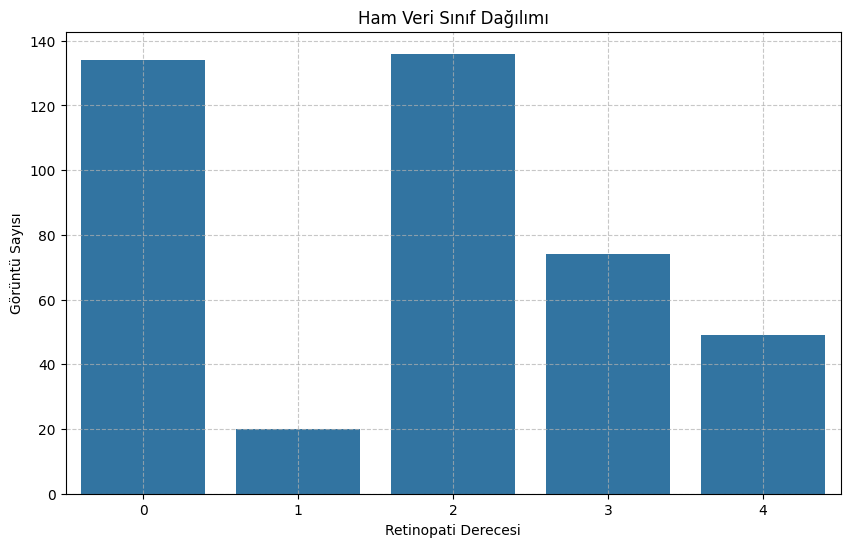

In [ ]:
# Sınıf dağılımını görselleştir
plt.figure(figsize=(10, 6))
class_dist = df['Retinopathy grade'].value_counts().sort_index()
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Ham Veri Sınıf Dağılımı')
plt.xlabel('Retinopati Derecesi')
plt.ylabel('Görüntü Sayısı')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f'{RESULT_DIR}/class_distribution_raw.png')
plt.show()

In [ ]:
# Gelişmiş görüntü ön işleme fonksiyonu
def preprocess_retina_image(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """Retina görüntülerini özel olarak işler"""
    try:
        # Görüntüyü oku
        img = cv2.imread(image_path)
        if img is None:
            return None

        # BGR'dan RGB'ye dönüştür
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Dairesel maske oluştur
        height, width = img.shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)
        center = (width // 2, height // 2)
        radius = min(width, height) // 2 - 10
        cv2.circle(mask, center, radius, 255, -1)

        # Maskeyi uygula
        masked_img = cv2.bitwise_and(img, img, mask=mask)

        # CLAHE ile kontrast geliştirme
        lab = cv2.cvtColor(masked_img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        enhanced_lab = cv2.merge((cl, a, b))
        enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

        # Gürültü azaltma
        denoised_img = cv2.bilateralFilter(enhanced_img, 9, 75, 75)

        # Yeniden boyutlandırma
        resized_img = cv2.resize(denoised_img, target_size)

        # VGG16 ön işleme
        processed_img = preprocess_input(resized_img)

        return processed_img

    except Exception as e:
        print(f"Görüntü işlenirken hata: {image_path} - {e}")
        return None


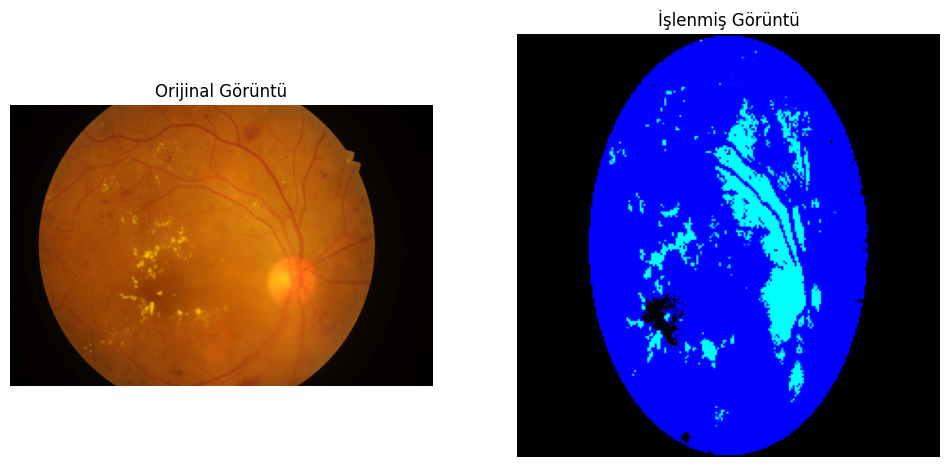

In [ ]:
# Örnek bir görüntüyü göster
example_image = os.path.join(image_dir, df.iloc[0]['Image name'] + '.jpg')
if os.path.exists(example_image):
    # Orijinal görüntü
    orig_img = cv2.imread(example_image)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # İşlenmiş görüntü
    proc_img = preprocess_retina_image(example_image)

    if proc_img is not None:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(orig_img)
        plt.title('Orijinal Görüntü')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        # VGG16 preprocessing değerlerini görüntülemek için normalize et
        proc_img_display = (proc_img + 1) / 2.0  # [-1,1] aralığını [0,1] aralığına dönüştür
        plt.imshow(np.clip(proc_img_display, 0, 1))
        plt.title('İşlenmiş Görüntü')
        plt.axis('off')

        plt.savefig(f'{RESULT_DIR}/example_preprocessing.png')
        plt.show()
    else:
        print("Örnek görüntü işlenemedi")


In [ ]:
# Veri setini oluştur
print("Veri seti hazırlanıyor...")
X = []
y = []
missing_count = 0

for idx, row in df.iterrows():
    if idx % 20 == 0:  # İlerleme göster
        print(f"İşlenen görüntü: {idx}/{len(df)}")

    img_name = row['Image name']
    grade = int(row['Retinopathy grade'])
    img_path = os.path.join(image_dir, img_name + '.jpg')

    if os.path.exists(img_path):
        img = preprocess_retina_image(img_path)
        if img is not None:
            X.append(img)
            y.append(grade)
        else:
            missing_count += 1
    else:
        print(f"Dosya bulunamadı: {img_path}")
        missing_count += 1

print(f"Toplam {missing_count} görüntü işlenemedi veya bulunamadı.")


Veri seti hazırlanıyor...
İşlenen görüntü: 0/413
İşlenen görüntü: 20/413
İşlenen görüntü: 40/413
İşlenen görüntü: 60/413
İşlenen görüntü: 80/413
İşlenen görüntü: 100/413
İşlenen görüntü: 120/413
İşlenen görüntü: 140/413
İşlenen görüntü: 160/413
İşlenen görüntü: 180/413
İşlenen görüntü: 200/413
İşlenen görüntü: 220/413
İşlenen görüntü: 240/413
İşlenen görüntü: 260/413
İşlenen görüntü: 280/413
İşlenen görüntü: 300/413
İşlenen görüntü: 320/413
İşlenen görüntü: 340/413
İşlenen görüntü: 360/413
İşlenen görüntü: 380/413
İşlenen görüntü: 400/413
Toplam 0 görüntü işlenemedi veya bulunamadı.


Veri seti şekli: X=(413, 224, 224, 3), y=(413, 5)
Sınıf dağılımı: {np.int64(0): np.int64(134), np.int64(1): np.int64(20), np.int64(2): np.int64(136), np.int64(3): np.int64(74), np.int64(4): np.int64(49)}


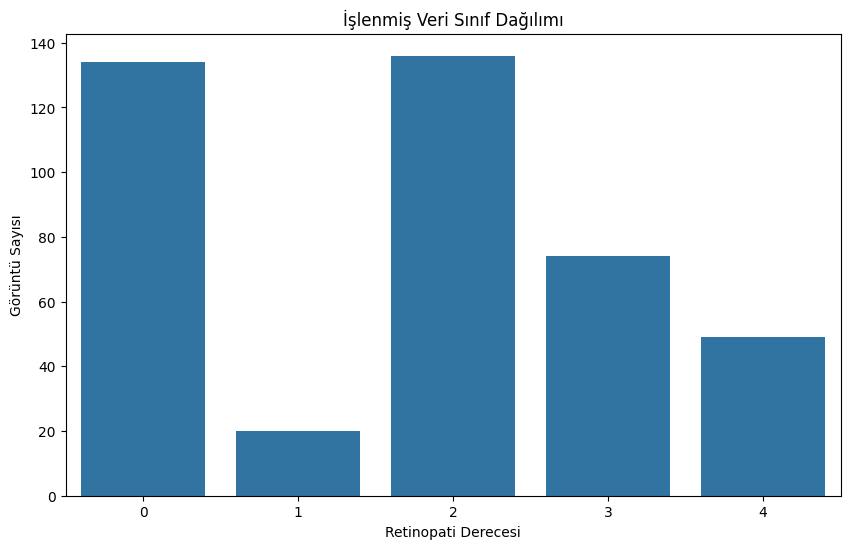

In [ ]:
# Numpy dizisine dönüştür
X = np.array(X)
y_orig = np.array(y)

# Etiketleri one-hot encoding format
y = to_categorical(y_orig, num_classes=NUM_CLASSES)

print(f"Veri seti şekli: X={X.shape}, y={y.shape}")

# Sınıf dağılımını kontrol et
unique, counts = np.unique(y_orig, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Sınıf dağılımı:", class_distribution)

# Sınıf dağılımını görselleştir
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('İşlenmiş Veri Sınıf Dağılımı')
plt.xlabel('Retinopati Derecesi')
plt.ylabel('Görüntü Sayısı')
plt.savefig(f'{RESULT_DIR}/processed_class_distribution.png')
plt.show()


In [ ]:
# Geliştirilmiş veri artırma ve dengeleme
print("Geliştirilmiş veri artırma ayarlanıyor...")
datagen = ImageDataGenerator(
    rotation_range=30,  # 20 -> 30
    width_shift_range=0.25,  # 0.2 -> 0.25
    height_shift_range=0.25,  # 0.2 -> 0.25
    zoom_range=0.3,  # 0.2 -> 0.3
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3],  # 0.8-1.2 -> 0.7-1.3
    channel_shift_range=0.2  # 0.1 -> 0.2
)

Geliştirilmiş veri artırma ayarlanıyor...


In [ ]:
# Sınıf dengeleme
max_samples_per_class = max(counts)
X_balanced = []
y_balanced = []

for class_idx in range(NUM_CLASSES):
    indices = np.where(y_orig == class_idx)[0]

    if len(indices) == 0:
        print(f"Uyarı: Sınıf {class_idx} için hiç örnek yok!")
        continue

    X_class = X[indices]
    y_class = y[indices]

    # Orijinal örnekleri ekle
    X_balanced.extend(X_class)
    y_balanced.extend(y_class)

    # Daha fazla örnek gerekiyorsa üret
    if len(indices) < max_samples_per_class:
        samples_needed = max_samples_per_class - len(indices)
        print(f"Sınıf {class_idx} için {samples_needed} örnek üretiliyor...")

        # Küçük gruplar halinde üret
        batch_size = min(len(X_class), 32)
        generated = 0

        for X_batch, y_batch in datagen.flow(
                X_class, y_class,
                batch_size=batch_size,
                shuffle=True):

            X_balanced.extend(X_batch)
            y_balanced.extend(y_batch)
            generated += len(X_batch)

            if generated >= samples_needed:
                break


Sınıf 0 için 32 örnek üretiliyor...
Sınıf 1 için 146 örnek üretiliyor...
Sınıf 2 için 30 örnek üretiliyor...
Sınıf 3 için 92 örnek üretiliyor...
Sınıf 4 için 117 örnek üretiliyor...


Dengeli veri seti şekli: X=(873, 224, 224, 3), y=(873, 5)
Dengeli sınıf dağılımı: {np.int64(0): np.int64(166), np.int64(1): np.int64(180), np.int64(2): np.int64(168), np.int64(3): np.int64(180), np.int64(4): np.int64(179)}


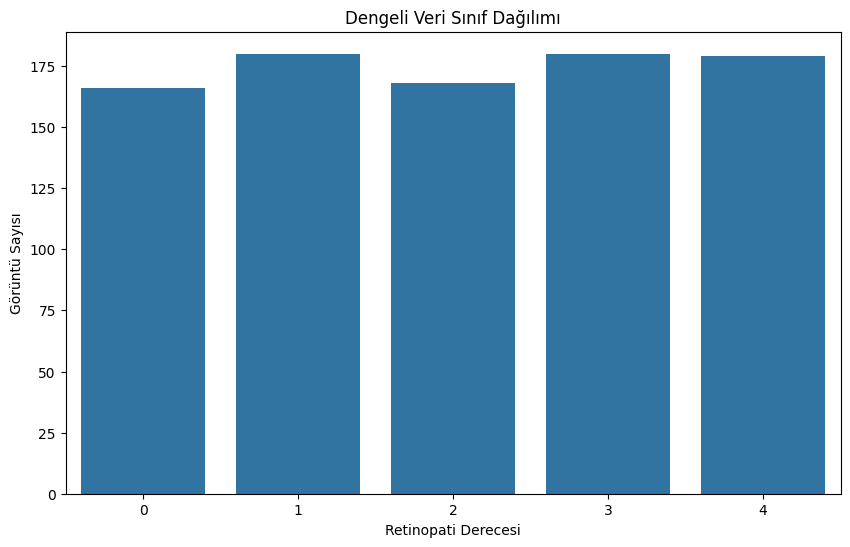

In [ ]:
# Numpy dizilerine dönüştür
X_balanced = np.array(X_balanced)
y_balanced = np.array(y_balanced)

print(f"Dengeli veri seti şekli: X={X_balanced.shape}, y={y_balanced.shape}")

# Dengeli sınıf dağılımı
y_balanced_classes = np.argmax(y_balanced, axis=1)
unique, counts = np.unique(y_balanced_classes, return_counts=True)
balanced_distribution = dict(zip(unique, counts))
print("Dengeli sınıf dağılımı:", balanced_distribution)

# Dengeli sınıf dağılımını görselleştir
plt.figure(figsize=(10, 6))
sns.barplot(x=list(balanced_distribution.keys()), y=list(balanced_distribution.values()))
plt.title('Dengeli Veri Sınıf Dağılımı')
plt.xlabel('Retinopati Derecesi')
plt.ylabel('Görüntü Sayısı')
plt.savefig(f'{RESULT_DIR}/balanced_class_distribution.png')
plt.show()

In [ ]:
# Veri setini böl (eğitim/validasyon/test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.15,
    random_state=42,
    stratify=y_balanced_classes
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.15,
    random_state=42,
    stratify=np.argmax(y_train_val, axis=1)
)

print(f"Eğitim seti: {X_train.shape}, {y_train.shape}")
print(f"Validasyon seti: {X_val.shape}, {y_val.shape}")
print(f"Test seti: {X_test.shape}, {y_test.shape}")


Eğitim seti: (630, 224, 224, 3), (630, 5)
Validasyon seti: (112, 224, 224, 3), (112, 5)
Test seti: (131, 224, 224, 3), (131, 5)


In [ ]:
# L2 regülarizasyonu ve artırılmış model kapasitesi ile VGG16 modeli
def create_vgg16_model_balanced():
    """Dengelenmiş L2 regülarizasyonu ve daha fazla nöron ile VGG16 tabanlı model oluşturur"""
    print("Yeni dengeli VGG16 modeli oluşturuluyor...")

    # VGG16 temel modelini yükle
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    # Başlangıçta tüm katmanları dondur
    for layer in base_model.layers:
        layer.trainable = False

    # Nöron sayısı arttırılmış ve daha az regülarizasyon ile model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(DROPOUT_RATE),
        Dense(768, activation='relu',  # 512 -> 768 nöron
              kernel_regularizer=l2(L2_LAMBDA),
              bias_regularizer=l2(L2_LAMBDA)),
        Dropout(DROPOUT_RATE),
        Dense(384, activation='relu',  # 256 -> 384 nöron
              kernel_regularizer=l2(L2_LAMBDA)),
        Dropout(DROPOUT_RATE/2),
        Dense(NUM_CLASSES, activation='softmax',
              kernel_regularizer=l2(L2_LAMBDA/10))
    ])

    # Modeli derle
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Dengeli modeli oluştur
model = create_vgg16_model_balanced()
model.summary()

Yeni dengeli VGG16 modeli oluşturuluyor...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 768)            │       393,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 384)            │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │         1,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,405,893 (58.77 MB)

 Trainable params: 691,205 (2.64 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Callback fonksiyonları
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,  # Daha sabırlı early stopping (15 -> 20)
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,  # Daha sabırlı lr azaltma (7 -> 10)
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [ ]:
# İlk eğitim (feature extraction)
print("Model eğitimi başlıyor (1. aşama)...")
history_initial = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=20,  # İlk aşama için daha uzun (15 -> 20)
    validation_data=(X_val, y_val),
    callbacks=callbacks
)
# Fine-tuning için daha fazla bloğu çöz
print("Geliştirilmiş fine-tuning hazırlanıyor...")
# Önce tüm katmanları dondur
for layer in model.layers[0].layers:
    layer.trainable = False

# Son 8 yerine, sadece son 5-6 katmanı çöz
for layer in model.layers[0].layers[-6:]:
    layer.trainable = True

# Daha düşük öğrenme oranı ile yeniden derle (ancak öncekinden biraz daha yüksek)
model.compile(
    optimizer=Adam(learning_rate= 2 * LEARNING_RATE/5),  # 5e-4/5 = 1e-4
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model eğitimi başlıyor (1. aşama)...
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2344 - loss: 6.0017
Epoch 1: val_accuracy improved from -inf to 0.40179, saving model to /content/drive/MyDrive/dr_vgg16_model_regularized.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.2352 - loss: 5.9848 - val_accuracy: 0.4018 - val_loss: 2.0007 - learning_rate: 5.0000e-04
Epoch 2/20
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3459 - loss: 3.7029
Epoch 2: val_accuracy improved from 0.40179 to 0.50893, saving model to /content/drive/MyDrive/dr_vgg16_model_regularized.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3458 - loss: 3.6954 - val_accuracy: 0.5089 - val_loss: 1.7581 - learning_rate: 5.0000e-04
Epoch 3/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3400 - loss: 3.2377
Epoch 3: val_accuracy did not improve from 0.50893
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3404 - loss: 3.2150 - val_accuracy: 0.4732 - val_loss: 1.7720 - learning_rate: 5.0000e-04
Epoch 4/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3745 - loss: 2.6393
Epoch 4: val_accuracy improved from 0.50893 to 0.51786, saving model to /content/drive/MyDrive/dr_vgg16_model_regularized.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3757 - loss: 2.6275 - val_accuracy: 0.5179 - val_loss: 1.6865 - learning_rate: 5.0000e-04
Epoch 5/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3479 - loss: 2.4441
Epoch 5: val_accuracy did not improve from 0.51786
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3489 - loss: 2.4358 - val_accuracy: 0.4375 - val_loss: 1.8030 - learning_rate: 5.0000e-04
Epoch 6/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3839 - loss: 2.2522
Epoch 6: val_accuracy did not improve from 0.51786
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3831 - loss: 2.2506 - val_accuracy: 0.4464 - val_loss: 1.8426 - learning_rate: 5.0000e-04
Epoch 7/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4183 - loss: 2.0719
Epoch 7: val_accuracy did not improve from 0.51786
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4177 - loss: 2.0724 - val_accuracy: 0.4643 - val_loss: 1.7517 - learning_rate: 5.0000e-04
Epoch 8/20
36/40

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4369 - loss: 1.9428 - val_accuracy: 0.5268 - val_loss: 1.7602 - learning_rate: 5.0000e-04
Epoch 11/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4101 - loss: 1.8951
Epoch 11: val_accuracy improved from 0.52679 to 0.55357, saving model to /content/drive/MyDrive/dr_vgg16_model_regularized.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4123 - loss: 1.8959 - val_accuracy: 0.5536 - val_loss: 1.7460 - learning_rate: 5.0000e-04
Epoch 12/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3730 - loss: 1.9263
Epoch 12: val_accuracy did not improve from 0.55357
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3766 - loss: 1.9211 - val_accuracy: 0.5536 - val_loss: 1.7551 - learning_rate: 5.0000e-04
Epoch 13/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4260 - loss: 1.8439
Epoch 13: val_accuracy did not improve from 0.55357
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4271 - loss: 1.8431 - val_accuracy: 0.4554 - val_loss: 1.7741 - learning_rate: 5.0000e-04
Epoch 14/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4399 - loss: 1.8236
Epoch 14: val_accuracy improved from 0.55357 to 0.56250, saving model to /content/drive/MyDrive/dr_vgg16_model_regularized.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4423 - loss: 1.8149 - val_accuracy: 0.5625 - val_loss: 1.6845 - learning_rate: 5.0000e-04
Epoch 15/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4855 - loss: 1.7224
Epoch 15: val_accuracy did not improve from 0.56250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4837 - loss: 1.7220 - val_accuracy: 0.5536 - val_loss: 1.6549 - learning_rate: 5.0000e-04
Epoch 16/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4529 - loss: 1.7371
Epoch 16: val_accuracy did not improve from 0.56250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4531 - loss: 1.7393 - val_accuracy: 0.5000 - val_loss: 1.6568 - learning_rate: 5.0000e-04
Epoch 17/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5207 - loss: 1.6793
Epoch 17: val_accuracy did not improve from 0.56250
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5194 - loss: 1.6810 - val_accuracy: 0.5089 - val_loss: 1.6776 - learning_rate: 5.0000e-04
Epoch 18/2

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4694 - loss: 1.6902 - val_accuracy: 0.5804 - val_loss: 1.6815 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 20.
Geliştirilmiş fine-tuning hazırlanıyor...


In [ ]:
# Eğitilebilir parametreleri göster
trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f'Eğitilebilir parametreler: {trainable_count:,}')
print(f'Eğitilemez parametreler: {non_trainable_count:,}')

Eğitilebilir parametreler: 10,130,437
Eğitilemez parametreler: 5,275,456


In [ ]:
# İkinci eğitim (fine-tuning)
print("Fine-tuning başlıyor (2. aşama)...")
history_fine = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,  # Toplam epoch sayısı
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# En iyi modeli yükle
model.load_weights(MODEL_PATH)
print("En iyi model yüklendi!")

Fine-tuning başlıyor (2. aşama)...
Epoch 21/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2857 - loss: 2.3913
Epoch 21: val_accuracy did not improve from 0.58036
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.2858 - loss: 2.3852 - val_accuracy: 0.3482 - val_loss: 1.7951 - learning_rate: 2.0000e-04
Epoch 22/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3899 - loss: 1.8309
Epoch 22: val_accuracy did not improve from 0.58036
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3896 - loss: 1.8314 - val_accuracy: 0.4464 - val_loss: 1.8638 - learning_rate: 2.0000e-04
Epoch 23/40
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3199 - loss: 1.8240
Epoch 23: val_accuracy did not improve from 0.58036
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3212 - loss: 1.8236 - val_accuracy: 0.4018 - val_loss: 1.7281 - learning_rate: 2.0000e-04
Epoch 24/40
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3889 - loss: 1.7374
Epoch 24: val_accuracy did not 

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5437 - loss: 1.4075 - val_accuracy: 0.6339 - val_loss: 1.2559 - learning_rate: 2.0000e-04
Epoch 29/40
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5898 - loss: 1.2852
Epoch 29: val_accuracy did not improve from 0.63393
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5902 - loss: 1.2847 - val_accuracy: 0.5268 - val_loss: 1.3161 - learning_rate: 2.0000e-04
Epoch 30/40
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6162 - loss: 1.1940
Epoch 30: val_accuracy improved from 0.63393 to 0.67857, saving model to /content/drive/MyDrive/dr_vgg16_model_regularized.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6170 - loss: 1.1897 - val_accuracy: 0.6786 - val_loss: 1.1236 - learning_rate: 2.0000e-04
Epoch 31/40
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5864 - loss: 1.2270
Epoch 31: val_accuracy did not improve from 0.67857
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5841 - loss: 1.2298 - val_accuracy: 0.5893 - val_loss: 1.1976 - learning_rate: 2.0000e-04
Epoch 32/40
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6421 - loss: 1.0097
Epoch 32: val_accuracy did not improve from 0.67857
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6446 - loss: 1.0162 - val_accuracy: 0.6518 - val_loss: 1.3872 - learning_rate: 2.0000e-04
Epoch 33/40
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7465 - loss: 0.9353
Epoch 33: val_accuracy did not improve from 0.67857
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7431 - loss: 0.9397 - val_accuracy: 0.6696 - val_loss: 1.1103 - learning_rate: 2.0000e-04
Epoch 34/4

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7688 - loss: 0.8330 - val_accuracy: 0.7143 - val_loss: 1.0306 - learning_rate: 2.0000e-04
Epoch 37/40
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7792 - loss: 0.8334
Epoch 37: val_accuracy did not improve from 0.71429
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7803 - loss: 0.8325 - val_accuracy: 0.6339 - val_loss: 2.0403 - learning_rate: 2.0000e-04
Epoch 38/40
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8069 - loss: 0.7405
Epoch 38: val_accuracy did not improve from 0.71429
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8081 - loss: 0.7385 - val_accuracy: 0.6786 - val_loss: 1.8326 - learning_rate: 2.0000e-04
Epoch 39/40
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8142 - loss: 0.7883
Epoch 39: val_accuracy did not improve from 0.71429
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8152 - loss: 0.7803 - val_accuracy: 0.6875 - val_loss: 1.2520 - learning_rate: 2.0000e-04
Epoch 40/4

Test seti değerlendiriliyor...
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 891ms/step - accuracy: 0.7587 - loss: 1.0627
Test kaybı: 1.0613
Test doğruluğu: 0.7710


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        25
           1       0.86      0.89      0.87        27
           2       0.68      0.52      0.59        25
           3       0.68      0.85      0.75        27
           4       0.88      0.81      0.85        27

    accuracy                           0.77       131
   macro avg       0.77      0.77      0.76       131
weighted avg       0.77      0.77      0.77       131

Weighted F1 Score: 0.7675


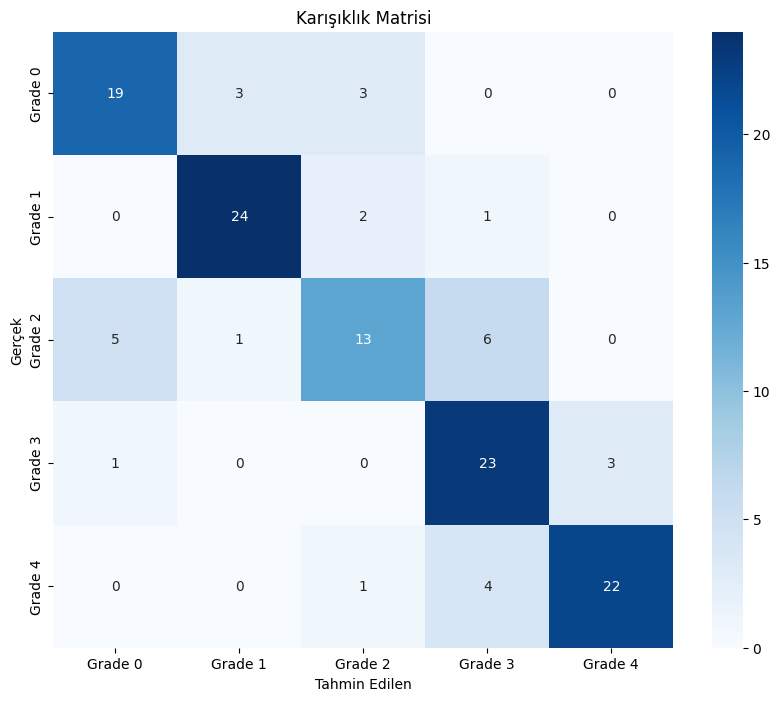

In [ ]:
# Test veri seti üzerinde değerlendirme
print("Test seti değerlendiriliyor...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test kaybı: {test_loss:.4f}")
print(f"Test doğruluğu: {test_acc:.4f}")

# Tahminler
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
report = classification_report(y_true_classes, y_pred_classes)
print("Sınıflandırma Raporu:")
print(report)

# F1 skoru
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# Karışıklık matrisi
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Grade {i}' for i in range(NUM_CLASSES)],
            yticklabels=[f'Grade {i}' for i in range(NUM_CLASSES)])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.savefig(f'{RESULT_DIR}/confusion_matrix.png')
plt.show()


In [ ]:
# Eğitim geçmişini birleştir ve kontrollerle görselleştir
print("Eğitim geçmişi bilgileri kontrol ediliyor...")

# history_initial ve history_fine değişkenlerini kontrol et
if 'history_initial' in locals() and hasattr(history_initial, 'history'):
    print("İlk eğitim geçmişi mevcut. İçerdiği metrikler:", list(history_initial.history.keys()))
    print("İlk eğitim epoch sayısı:", len(history_initial.history['accuracy']))
else:
    print("UYARI: İlk eğitim geçmişi (history_initial) bulunamadı veya beklenen formatta değil!")

if 'history_fine' in locals() and hasattr(history_fine, 'history'):
    print("Fine-tuning eğitim geçmişi mevcut. İçerdiği metrikler:", list(history_fine.history.keys()))
    print("Fine-tuning epoch sayısı:", len(history_fine.history['accuracy']))
else:
    print("UYARI: Fine-tuning eğitim geçmişi (history_fine) bulunamadı veya beklenen formatta değil!")

# history_dict'i güvenli bir şekilde oluştur
history_dict = {}

if 'history_initial' in locals() and hasattr(history_initial, 'history'):
    for k, v in history_initial.history.items():
        history_dict[k] = list(v)  # Listeye dönüştür

if 'history_fine' in locals() and hasattr(history_fine, 'history'):
    for k, v in history_fine.history.items():
        if k in history_dict:
            history_dict[k].extend(list(v))  # Listeye dönüştür ve ekle
        else:
            history_dict[k] = list(v)  # Listeye dönüştür

print("Birleştirilmiş geçmiş içeriği:", list(history_dict.keys()))
for k, v in history_dict.items():
    print(f"  {k}: {len(v)} değer")

# Eğitim geçmişini görselleştir
plt.figure(figsize=(16, 6))


Eğitim geçmişi bilgileri kontrol ediliyor...
İlk eğitim geçmişi mevcut. İçerdiği metrikler: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']
İlk eğitim epoch sayısı: 20
Fine-tuning eğitim geçmişi mevcut. İçerdiği metrikler: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']
Fine-tuning epoch sayısı: 20
Birleştirilmiş geçmiş içeriği: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']
  accuracy: 40 değer
  loss: 40 değer
  val_accuracy: 40 değer
  val_loss: 40 değer
  learning_rate: 40 değer


<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

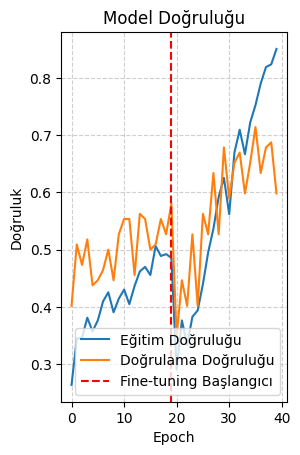

In [ ]:
# Doğruluk grafiği
plt.subplot(1, 2, 1)
if 'accuracy' in history_dict and len(history_dict['accuracy']) > 0:
    plt.plot(history_dict['accuracy'], label='Eğitim Doğruluğu')

    if 'val_accuracy' in history_dict:
        plt.plot(history_dict['val_accuracy'], label='Doğrulama Doğruluğu')

    if 'history_initial' in locals() and hasattr(history_initial, 'history') and 'accuracy' in history_initial.history:
        plt.axvline(x=len(history_initial.history['accuracy'])-1, color='r', linestyle='--',
                label='Fine-tuning Başlangıcı')

    plt.title('Model Doğruluğu')
    plt.ylabel('Doğruluk')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower right')
else:
    plt.text(0.5, 0.5, 'Doğruluk verisi yok', horizontalalignment='center', verticalalignment='center')


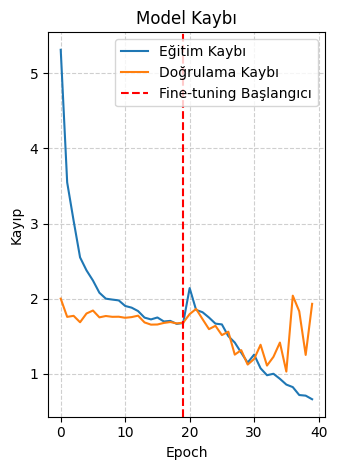

In [ ]:
# Kayıp grafiği
plt.subplot(1, 2, 2)
if 'loss' in history_dict and len(history_dict['loss']) > 0:
    plt.plot(history_dict['loss'], label='Eğitim Kaybı')

    if 'val_loss' in history_dict:
        plt.plot(history_dict['val_loss'], label='Doğrulama Kaybı')

    if 'history_initial' in locals() and hasattr(history_initial, 'history') and 'loss' in history_initial.history:
        plt.axvline(x=len(history_initial.history['loss'])-1, color='r', linestyle='--',
                label='Fine-tuning Başlangıcı')

    plt.title('Model Kaybı')
    plt.ylabel('Kayıp')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')
else:
    plt.text(0.5, 0.5, 'Kayıp verisi yok', horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/training_history.png')
plt.show()

In [ ]:
# Yanlış sınıflandırmaları görselleştir
def visualize_misclassifications(X_test, y_true, y_pred, n=5):
    misclassified = np.where(y_true != y_pred)[0]

    if len(misclassified) == 0:
        print("Yanlış sınıflandırılan örnek yok!")
        return

    n = min(n, len(misclassified))
    indices = np.random.choice(misclassified, size=n, replace=False)

    plt.figure(figsize=(15, 5*n))
    for i, idx in enumerate(indices):
        img = X_test[idx]
        img = (img + 1) / 2.0  # [-1,1] -> [0,1]
        img = np.clip(img, 0, 1)

        plt.subplot(n, 1, i+1)
        plt.imshow(img)
        plt.title(f"Gerçek: Grade {y_true[idx]}, Tahmin: Grade {y_pred[idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'{RESULT_DIR}/misclassifications.png')
    plt.show()

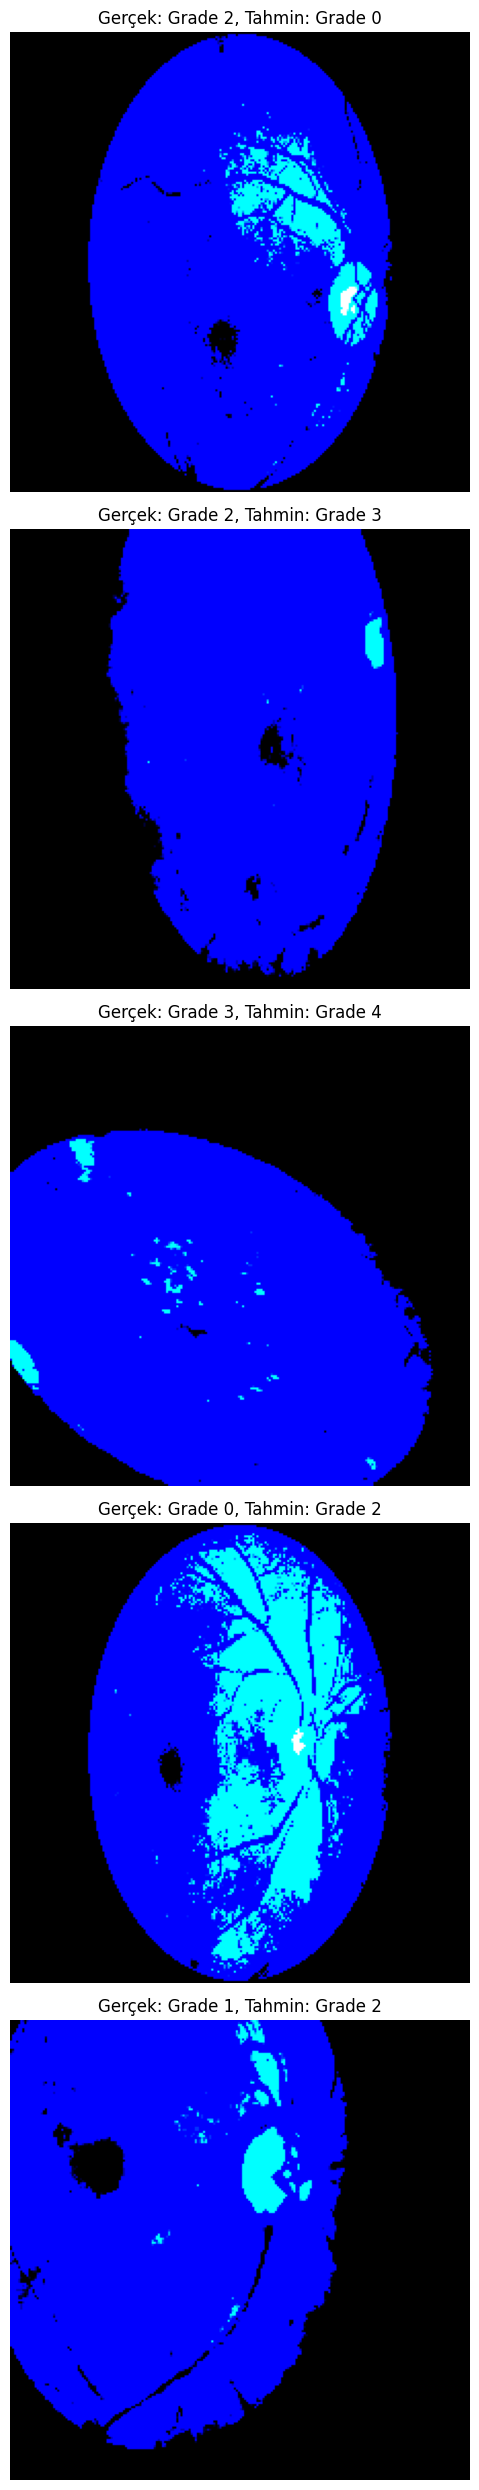

Regülarizasyon iyileştirmeleri ile tüm işlemler başarıyla tamamlandı!

--- Regülarizasyon İyileştirmeleri Özeti ---
1. Dropout oranı 0.5 olarak artırıldı (önceden 0.5)
2. L2 regülarizasyonu eklendi (katsayı = 0.0005)
3. Daha sabırlı Early Stopping (patience = 15)
4. Fine-tuning için daha düşük öğrenme oranı
5. Örnek dengeleme ve geliştirilmiş veri artırma


In [ ]:
# Yanlış sınıflandırmaları göster
visualize_misclassifications(X_test, y_true_classes, y_pred_classes)

print("Regülarizasyon iyileştirmeleri ile tüm işlemler başarıyla tamamlandı!")

# Modelin özeti ve iyileştirmeler
print("\n--- Regülarizasyon İyileştirmeleri Özeti ---")
print(f"1. Dropout oranı {DROPOUT_RATE} olarak artırıldı (önceden 0.5)")
print(f"2. L2 regülarizasyonu eklendi (katsayı = {L2_LAMBDA})")
print(f"3. Daha sabırlı Early Stopping (patience = 15)")
print("4. Fine-tuning için daha düşük öğrenme oranı")
print("5. Örnek dengeleme ve geliştirilmiş veri artırma")